In [222]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,root_mean_squared_error
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor

from utils import clean_data
from utils import split_trajectories
from utils import replicate_initial_position_by_block
from utils import plot_y_yhat

In [223]:
train = pd.read_csv('../data/X_train.csv')
test =  pd.read_csv('../data/X_test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')#This is a file with random numbers as predictions

In [224]:
train_cleaned=clean_data(train)

In [225]:
train_after_split, validation_after_split, test_after_split = split_trajectories(train_cleaned)

In [226]:
print(train_after_split.shape)
print(validation_after_split.shape)
print(test_after_split.shape)

(654132, 14)
(219659, 14)
(215999, 14)


In [227]:
# VERIFY THAT TRAIN, VALIDATION, AND TEST SETS HAVE NO OVERLAP
train_ids = set(train_after_split['Id'].unique())
val_ids = set(validation_after_split['Id'].unique())
test_ids = set(test_after_split['Id'].unique())

print("Train ∩ Validation :", train_ids & val_ids)
print("Train ∩ Test :", train_ids & test_ids)
print("Validation ∩ Test :", val_ids & test_ids)

Train ∩ Validation : set()
Train ∩ Test : set()
Validation ∩ Test : set()


In [228]:
train_entry=replicate_initial_position_by_block(train_after_split)
validation_entry=replicate_initial_position_by_block(validation_after_split)
test_entry=replicate_initial_position_by_block(test_after_split)

LINEAR REGRESSION

In [229]:
pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

input_cols = ['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
target_cols = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']

X_train = train_entry[input_cols]          
y_train = train_after_split[target_cols] 

pipeline.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

COEFFICIENT VISUALIZATION


Coefficients pour x_1 :
  t: -0.5592425526189578
  x_1: 0.0
  y_1: 0.0
  x_2: 0.2544034670084157
  y_2: -0.14972056468720982
  x_3: -0.25440346700841565
  y_3: 0.14972056468720987
Intercept: -0.34875403730443194

Coefficients pour y_1 :
  t: -0.04860406368089074
  x_1: 6.938893903907228e-18
  y_1: 0.0
  x_2: 0.011200754600463634
  y_2: -0.12297532261195347
  x_3: -0.011200754600463703
  y_3: 0.12297532261195353
Intercept: -0.12662838906491766

Coefficients pour x_2 :
  t: 0.08005751283133644
  x_1: 0.0
  y_1: 1.734723475976807e-18
  x_2: -0.05646427004668142
  y_2: -0.029319329956303514
  x_3: 0.05646427004668137
  y_3: 0.029319329956303528
Intercept: 0.015553179957738398

Coefficients pour y_2 :
  t: -0.2476458123739558
  x_1: 0.0
  y_1: 0.0
  x_2: 0.044782399998859586
  y_2: -0.03111805499109908
  x_3: -0.044782399998859565
  y_3: 0.031118054991099094
Intercept: -0.09724066936691908

Coefficients pour x_3 :
  t: 0.4791850397921392
  x_1: 0.0
  y_1: 0.0
  x_2: -0.19793919696679232
  

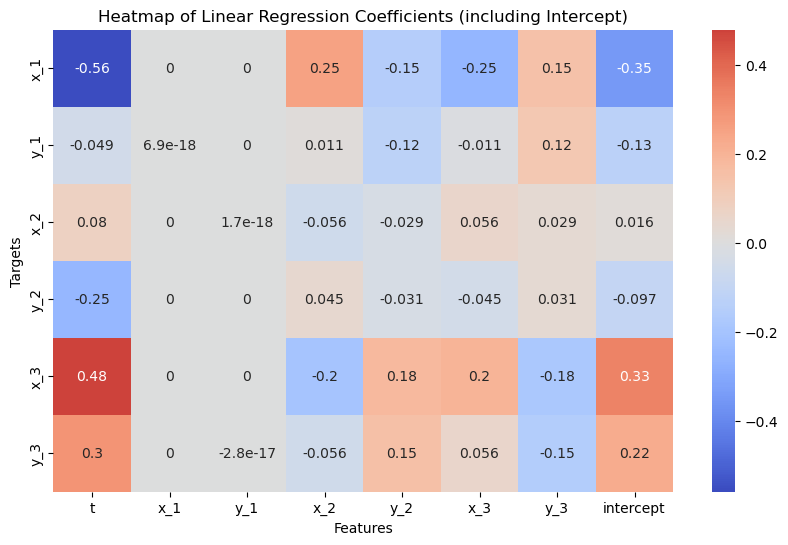

In [230]:
coefficients = pipeline.named_steps['linearregression'].coef_  # shape = (n_targets, n_features)
intercepts = pipeline.named_steps['linearregression'].intercept_  # shape = (n_targets,)

# Afficher les coefficients pour chaque target
for i, target in enumerate(target_cols):
    print(f"\nCoefficients pour {target} :")
    for col, coef in zip(input_cols, coefficients[i]):
        print(f"  {col}: {coef}")
    print(f"Intercept: {intercepts[i]}")

coef_df = pd.DataFrame(coefficients, index=target_cols, columns=input_cols)
coef_df['intercept'] = intercepts  

plt.figure(figsize=(10, 6))
sns.heatmap(coef_df, annot=True, cmap='coolwarm', center=0)
plt.title("Heatmap of Linear Regression Coefficients (including Intercept)")
plt.xlabel("Features")
plt.ylabel("Targets")
plt.show()

ERROR VISUALIZATION

In [234]:
X_val = validation_entry[input_cols]
y_val = validation_after_split[target_cols]

y_pred_val = pipeline.predict(X_val) 

X_test = test_entry[input_cols]
y_test= test_after_split[target_cols]

y_pred_test = pipeline.predict(X_test) 


#rmse_validation = root_mean_squared_error(y_val,y_pred_val)
#print("RMSE validation:", rmse_validation)

rmse_test = root_mean_squared_error(y_test,y_pred_test)
print("RMSE test :", rmse_test)

RMSE test : 1.4217056446912988


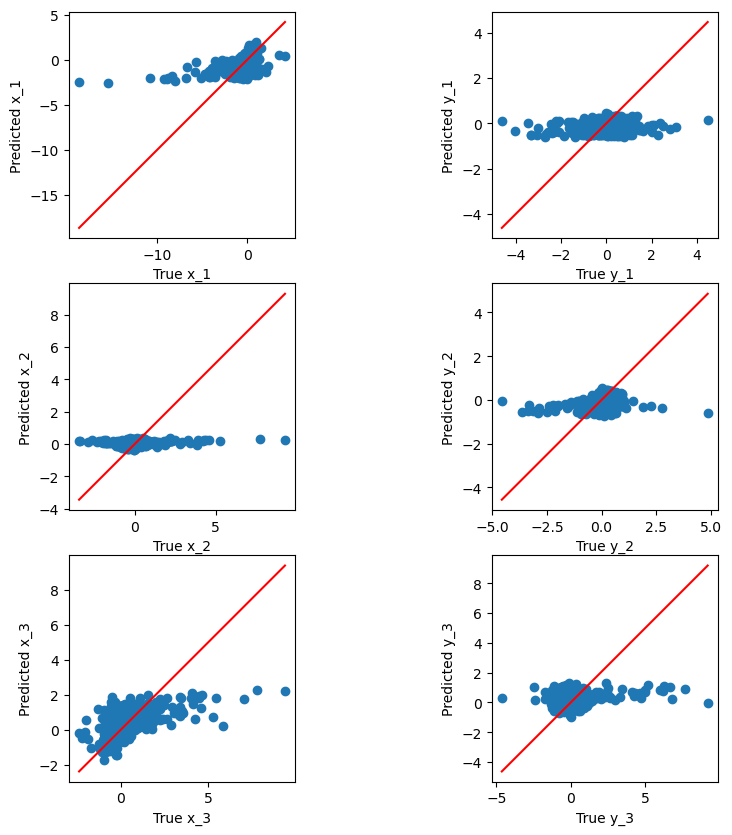

In [232]:
#Prends des points randoms si >500 points
plot_y_yhat(y_val.values, y_pred_val, plot_title="plot")

CREATE SUBMISSION CSV

In [233]:
X_test = test[['t','x0_1','y0_1','x0_2','y0_2','x0_3','y0_3']].copy()
X_test.columns = ['t','x_1','y_1','x_2','y_2','x_3','y_3']  # correspond aux input_cols du fit
ids = test['Id']

# Faire les prédictions
predictions = pipeline.predict(X_test)

# Créer le CSV de sortie
target_cols = ['x_1','y_1','x_2','y_2','x_3','y_3']
output_df = pd.DataFrame(predictions, columns=target_cols)
output_df.insert(0, 'Id', ids)
output_df.to_csv('baseline-model.csv', index=False)
